# Base Sequence Content QC for NGS Data

This notebook demonstrates how to use the `base_content` function from the `polars_bio.qc` module to analyze the base sequence content of FASTQ files. This QC operation helps identify biases or issues in the sequencing process by showing the distribution of nucleotide bases (A, T, G, C, N) at each position in the reads.

In [1]:
import polars_bio as pb
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os


# Set plotting style
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

INFO:polars_bio:Creating BioSessionContext


## Loading FASTQ Data

First, let's load a FASTQ file using the `read_fastq` function from polars-bio. We'll use the example FASTQ file from the fastqc-rs project.

In [2]:
# Path to the example FASTQ file
fastq_file = "../tests/data/example.fastq"

# Read the FASTQ file
pb.read_fastq(fastq_file).collect()
df = pb.read_fastq(fastq_file).collect()


INFO:polars_bio:Table: example registered for path: ../tests/data/example.fastq


0rows [00:00, ?rows/s]

INFO:polars_bio:Table: example registered for path: ../tests/data/example.fastq


0rows [00:00, ?rows/s]

In [3]:
# Register the DataFrame as a table
pb.sql("show tables;").collect()


0rows [00:00, ?rows/s]

table_catalog,table_schema,table_name,table_type
str,str,str,str
"""datafusion""","""public""","""example""","""BASE TABLE"""
"""datafusion""","""information_schema""","""tables""","""VIEW"""
"""datafusion""","""information_schema""","""views""","""VIEW"""
"""datafusion""","""information_schema""","""columns""","""VIEW"""
"""datafusion""","""information_schema""","""df_settings""","""VIEW"""
"""datafusion""","""information_schema""","""schemata""","""VIEW"""


In [4]:
pb.sql("select count(*) from example limit 10").collect()

0rows [00:00, ?rows/s]

count(*)
i64
563200


In [4]:
pb.sql("describe example").collect()

0rows [00:00, ?rows/s]

column_name,data_type,is_nullable
str,str,str
"""name""","""Utf8""","""NO"""
"""description""","""Utf8""","""YES"""
"""sequence""","""Utf8""","""NO"""
"""quality_scores""","""Utf8""","""NO"""


In [3]:
pb.sql("select base_content(sequence) from example;").collect()
pb.ctx.set_option("datafusion.execution.target_partitions", str(2))
pb.sql("select base_content(sequence) from example;").collect()


0rows [00:00, ?rows/s]

0rows [00:00, ?rows/s]

base_content(example.sequence)
struct[6]
"{0,21.0,25.5,24.0,23.0,6.5}"
"{1,24.0,25.5,20.0,30.5,0.0}"
"{2,28.5,25.5,21.5,24.5,0.0}"
"{3,22.5,24.0,26.0,27.5,0.0}"
"{4,28.5,22.5,23.0,26.0,0.0}"
…
"{96,27.0,21.0,26.0,22.5,3.5}"
"{97,23.0,22.0,26.0,23.5,5.5}"
"{98,23.0,27.5,26.0,23.5,0.0}"


In [3]:
pb.sql("select base_content(sequence) from example;").collect()
pb.ctx.set_option("datafusion.execution.target_partitions", str(2))
pb.sql("select base_content(sequence) from example;").collect()


0rows [00:00, ?rows/s]

0rows [00:00, ?rows/s]

base_content(example.sequence)
struct[6]
"{0,21.0,25.5,24.0,23.0,6.5}"
"{1,24.0,25.5,20.0,30.5,0.0}"
"{2,28.5,25.5,21.5,24.5,0.0}"
"{3,22.5,24.0,26.0,27.5,0.0}"
"{4,28.5,22.5,23.0,26.0,0.0}"
…
"{96,27.0,21.0,26.0,22.5,3.5}"
"{97,23.0,22.0,26.0,23.5,5.5}"
"{98,23.0,27.5,26.0,23.5,0.0}"


## Analyzing Base Sequence Content

Now, let's analyze the base sequence content using the `base_content` function. This function calculates the percentage of each base (A, T, G, C, N) at each position in the reads.

In [17]:
# Calculate base content
base_content_df = pb.qc.base_content(df)

# Display the first few rows of the result
base_content_df.head()

Chunk size: 70400
Successfully calculated base content, column count: 101


position,A,C,G,T,N
i32,f64,f64,f64,f64,f64
0,21.0,25.5,24.0,23.0,6.5
1,24.0,25.5,20.0,30.5,0.0
2,28.5,25.5,21.5,24.5,0.0
3,22.5,24.0,26.0,27.5,0.0
4,28.5,22.5,23.0,26.0,0.0


In [18]:
base_content_df = base_content_df.with_columns(
    pl.sum_horizontal(['A', 'C', 'G', 'T', 'N']).alias('total')
)
print(base_content_df)

shape: (101, 7)
┌──────────┬──────┬──────┬──────┬──────┬─────┬───────┐
│ position ┆ A    ┆ C    ┆ G    ┆ T    ┆ N   ┆ total │
│ ---      ┆ ---  ┆ ---  ┆ ---  ┆ ---  ┆ --- ┆ ---   │
│ i32      ┆ f64  ┆ f64  ┆ f64  ┆ f64  ┆ f64 ┆ f64   │
╞══════════╪══════╪══════╪══════╪══════╪═════╪═══════╡
│ 0        ┆ 21.0 ┆ 25.5 ┆ 24.0 ┆ 23.0 ┆ 6.5 ┆ 100.0 │
│ 1        ┆ 24.0 ┆ 25.5 ┆ 20.0 ┆ 30.5 ┆ 0.0 ┆ 100.0 │
│ 2        ┆ 28.5 ┆ 25.5 ┆ 21.5 ┆ 24.5 ┆ 0.0 ┆ 100.0 │
│ 3        ┆ 22.5 ┆ 24.0 ┆ 26.0 ┆ 27.5 ┆ 0.0 ┆ 100.0 │
│ 4        ┆ 28.5 ┆ 22.5 ┆ 23.0 ┆ 26.0 ┆ 0.0 ┆ 100.0 │
│ …        ┆ …    ┆ …    ┆ …    ┆ …    ┆ …   ┆ …     │
│ 96       ┆ 27.0 ┆ 21.0 ┆ 26.0 ┆ 22.5 ┆ 3.5 ┆ 100.0 │
│ 97       ┆ 23.0 ┆ 22.0 ┆ 26.0 ┆ 23.5 ┆ 5.5 ┆ 100.0 │
│ 98       ┆ 23.0 ┆ 27.5 ┆ 26.0 ┆ 23.5 ┆ 0.0 ┆ 100.0 │
│ 99       ┆ 27.0 ┆ 24.5 ┆ 23.0 ┆ 25.5 ┆ 0.0 ┆ 100.0 │
│ 100      ┆ 32.0 ┆ 17.0 ┆ 21.0 ┆ 30.0 ┆ 0.0 ┆ 100.0 │
└──────────┴──────┴──────┴──────┴──────┴─────┴───────┘


## Visualizing Base Sequence Content

Let's visualize the base content distribution across positions using the `visualize_base_content` function.

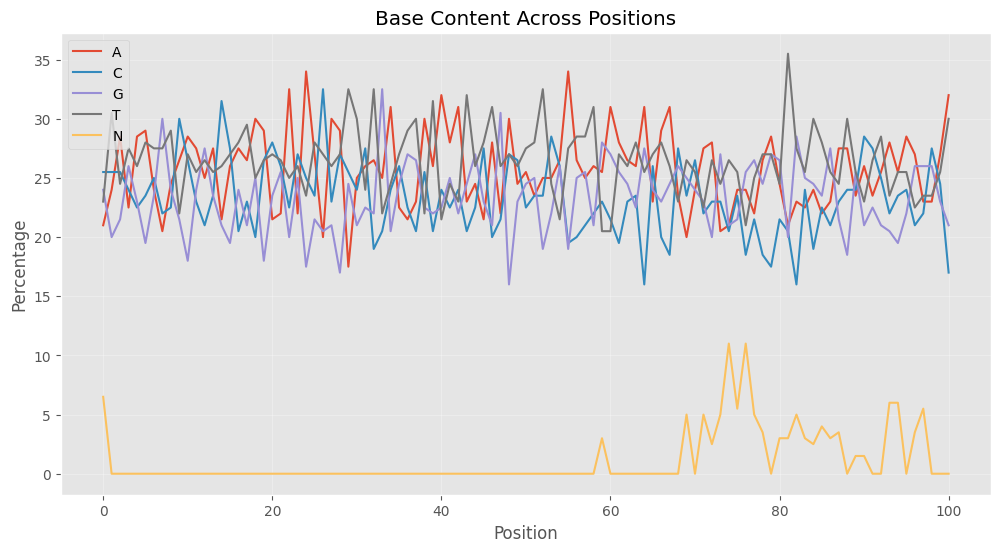

In [19]:
# Visualize base content
pb.qc.visualize_base_content(base_content_df)

## Custom Visualization

We can also create a custom visualization of the base content data using matplotlib directly.

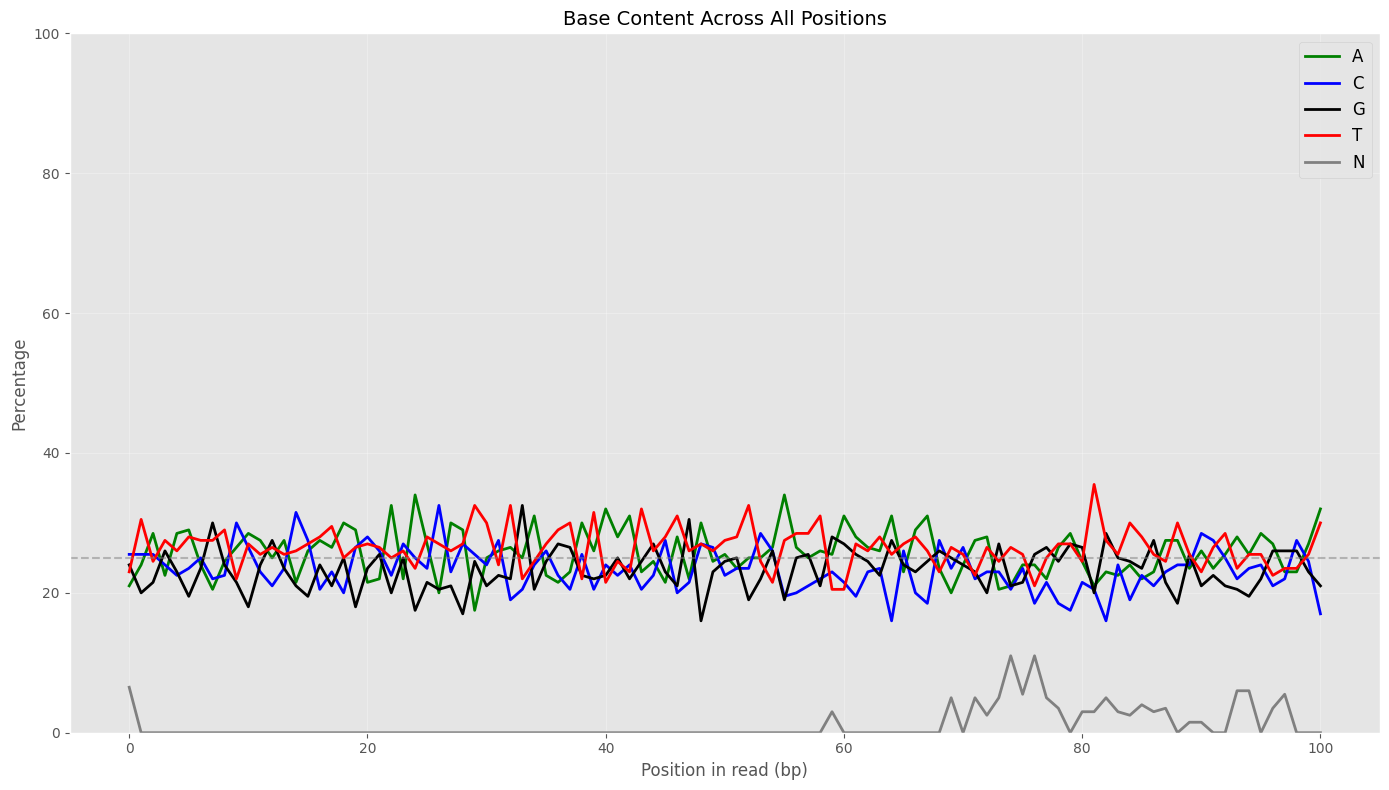

In [20]:
# Convert to pandas for easier plotting
pdf = base_content_df.to_pandas()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Plot each base
ax.plot(pdf['position'], pdf['A'], '-', label='A', color='green', linewidth=2)
ax.plot(pdf['position'], pdf['C'], '-', label='C', color='blue', linewidth=2)
ax.plot(pdf['position'], pdf['G'], '-', label='G', color='black', linewidth=2)
ax.plot(pdf['position'], pdf['T'], '-', label='T', color='red', linewidth=2)
ax.plot(pdf['position'], pdf['N'], '-', label='N', color='gray', linewidth=2)

# Add a horizontal line at 25% (expected for random distribution)
ax.axhline(y=25, color='gray', linestyle='--', alpha=0.5)

# Set labels and title
ax.set_xlabel('Position in read (bp)', fontsize=12)
ax.set_ylabel('Percentage', fontsize=12)
ax.set_title('Base Content Across All Positions', fontsize=14)

# Add legend
ax.legend(fontsize=12)

# Set y-axis limits
ax.set_ylim(0, 100)

# Add grid
ax.grid(True, alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

## Analyzing Base Content with Different Input Types

The `base_content` function supports different input types, including Polars DataFrame, Polars LazyFrame, and Pandas DataFrame. Let's demonstrate this flexibility.

In [17]:
# Using a Polars LazyFrame
lazy_df = df.lazy()
lazy_result = pb.qc.base_content(lazy_df)
print(f"Result type with LazyFrame input: {type(lazy_result)}")
lazy_result.head()

Successfully calculated base content, row count: 438
Result type with LazyFrame input: <class 'polars.dataframe.frame.DataFrame'>


position,A,C,G,T,N
i32,f64,f64,f64,f64,f64
0,2.253775,41.311697,46.743295,9.691233,0.0
1,27.65382,1.825558,34.550372,35.97025,0.0
2,15.663737,2.681992,25.467658,56.186613,0.0
3,13.657877,4.50755,35.406806,46.427767,0.0
4,17.421681,8.541808,31.778229,42.258283,0.0


In [18]:
# Using a Pandas DataFrame
pandas_df = df.to_pandas()
pandas_result = pb.qc.base_content(pandas_df, output_type="pandas.DataFrame")
print(f"Result type with Pandas DataFrame input: {type(pandas_result)}")
pandas_result.head()

Successfully calculated base content, row count: 438
Result type with Pandas DataFrame input: <class 'pandas.core.frame.DataFrame'>


,position,A,C,G,T,N
0,0,2.253775,41.311697,46.743295,9.691233,0.0
1,1,27.653820,1.825558,34.550372,35.970250,0.0
2,2,15.663737,2.681992,25.467658,56.186613,0.0
3,3,13.657877,4.507550,35.406806,46.427767,0.0
4,4,17.421681,8.541808,31.778229,42.258283,0.0


## Performance Comparison

Let's compare the performance of the base content calculation with different numbers of threads.

In [4]:
import time
import os
print(f"Number of CPU cores: {os.cpu_count()}")
# Define a function to measure execution time
def measure_time(func, *args, **kwargs):
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    return result, end_time - start_time

# Test with different numbers of threads
thread_counts = [1, 2, 4, 8]
execution_times = []
execution_times_sql = []
for threads in thread_counts:
    # Set the number of threads
    pb.ctx.set_option("datafusion.execution.target_partitions", str(threads))

    start_time = time.time()
    pb.sql("select base_content(sequence) from example").collect()
    end_time = time.time()
    execution_time_sql = end_time - start_time
    execution_times_sql.append(execution_time_sql)
    # Measure execution time
    _, execution_time = measure_time(pb.qc.base_content, df)
    execution_times.append(execution_time)

    print(f"Threads: {threads}, Execution time: {execution_time:.4f} seconds, Execution time SQL: {execution_time_sql:.4f} seconds")

Number of CPU cores: 12


0rows [00:00, ?rows/s]

Chunk size: 140800
Successfully calculated base content, column count: 101
Threads: 1, Execution time: 0.5347 seconds, Execution time SQL: 0.7332 seconds


0rows [00:00, ?rows/s]

Chunk size: 140800
Successfully calculated base content, column count: 101
Threads: 2, Execution time: 0.5203 seconds, Execution time SQL: 0.4870 seconds


0rows [00:00, ?rows/s]

Chunk size: 140800
Successfully calculated base content, column count: 101
Threads: 4, Execution time: 0.5376 seconds, Execution time SQL: 0.4735 seconds


0rows [00:00, ?rows/s]

Chunk size: 140800
Successfully calculated base content, column count: 101
Threads: 8, Execution time: 0.4676 seconds, Execution time SQL: 0.4171 seconds


In [ ]:
import time
import os
print(f"Number of CPU cores: {os.cpu_count()}")
# Define a function to measure execution time
def measure_time(func, *args, **kwargs):
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    return result, end_time - start_time

# Test with different numbers of threads
thread_counts = [1, 2, 4, 8]
execution_times = []
execution_times_sql = []
for threads in thread_counts:
    # Set the number of threads
    pb.ctx.set_option("datafusion.execution.target_partitions", str(threads))

    start_time = time.time()
    pb.sql("select base_content(sequence) from example").collect()
    end_time = time.time()
    execution_time_sql = end_time - start_time
    execution_times_sql.append(execution_time_sql)
    # Measure execution time
    _, execution_time = measure_time(pb.qc.base_content, df)
    execution_times.append(execution_time)

    print(f"Threads: {threads}, Execution time: {execution_time:.4f} seconds, Execution time SQL: {execution_time_sql:.4f} seconds")

Number of CPU cores: 12


0rows [00:00, ?rows/s]

Chunk size: 140800
Successfully calculated base content, column count: 101
Threads: 1, Execution time: 1.3817 seconds, Execution time SQL: 3.5259 seconds


0rows [00:00, ?rows/s]

ComputeError: caught exception during execution of a Python source, exception: Exception: Arrow error: Invalid argument error: number of columns(7) must match number of fields(0) in schema

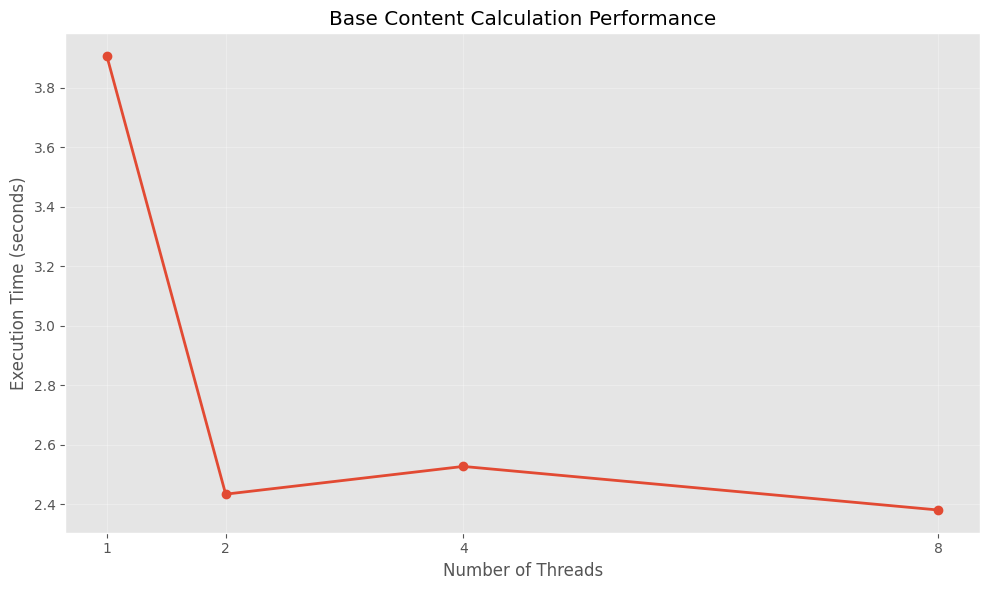

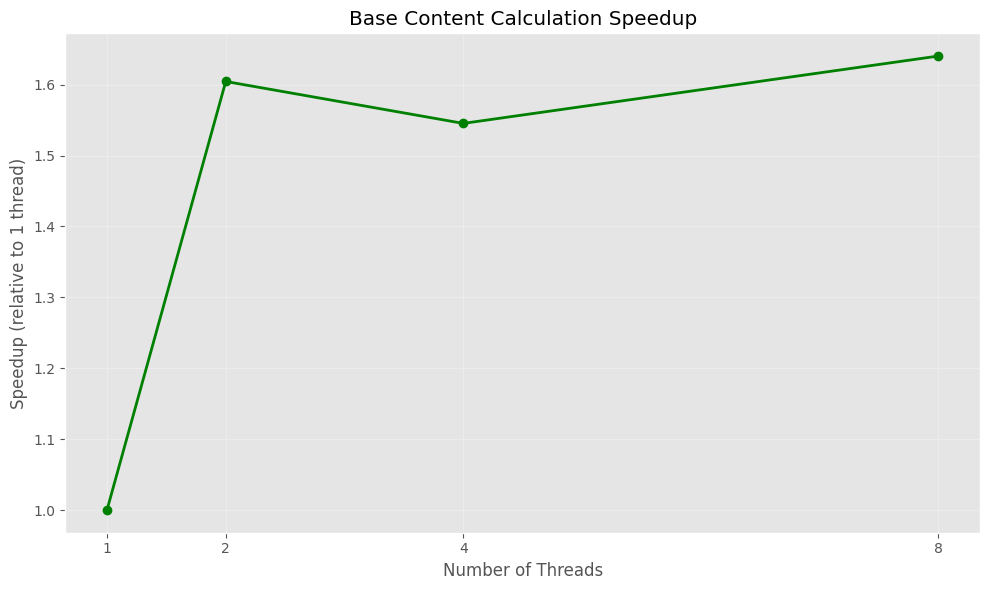

In [21]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(thread_counts, execution_times, 'o-', linewidth=2)
plt.xlabel('Number of Threads')
plt.ylabel('Execution Time (seconds)')
plt.title('Base Content Calculation Performance')
plt.grid(True, alpha=0.3)
plt.xticks(thread_counts)
plt.tight_layout()
plt.show()

# Calculate speedup
baseline_time = execution_times[0]  # Time with 1 thread
speedups = [baseline_time / time for time in execution_times]

plt.figure(figsize=(10, 6))
plt.plot(thread_counts, speedups, 'o-', linewidth=2, color='green')
plt.xlabel('Number of Threads')
plt.ylabel('Speedup (relative to 1 thread)')
plt.title('Base Content Calculation Speedup')
plt.grid(True, alpha=0.3)
plt.xticks(thread_counts)
plt.tight_layout()
plt.show()

## Conclusion

In this notebook, we demonstrated how to use the `base_content` function from the `polars_bio.qc` module to analyze and visualize the base sequence content of FASTQ files. This QC operation helps identify biases or issues in the sequencing process.

Key points:
- The function calculates the percentage of each base (A, T, G, C, N) at each position in the reads
- It supports different input types (Polars DataFrame, Polars LazyFrame, Pandas DataFrame)
- The operation can be parallelized for better performance on larger datasets
- The results can be easily visualized to identify patterns or anomalies in the data

This QC operation is an essential part of NGS data analysis pipelines, helping researchers ensure the quality of their sequencing data before proceeding with downstream analyses.